<a href="https://colab.research.google.com/github/larrymoralez/ML-HW-3/blob/master/ML_HW_3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras import backend as K
import numpy as np
import os
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import time
import pandas as pd
from sklearn.manifold import TSNE

In [10]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-19 22:54:31--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  51.6MB/s    in 1.3s    

2019-04-19 22:54:32 (51.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [36]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

dir = '/tmp/cats_and_dogs_filtered'

train_data = os.path.join(dir, 'train')
val_data = os.path.join(dir, 'validation')

train_cats = os.path.join(train_data, 'cats')
train_dogs = os.path.join(train_data, 'dogs')
val_cats = os.path.join(val_data, 'cats')
val_dogs = os.path.join(val_data, 'dogs')


/tmp/cats_and_dogs_filtered/validation/dogs


In [0]:
conv_base = VGG19(weights = 'imagenet',
              include_top=False, 
              input_shape=(150, 150, 3))

#conv_base.summary()

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#model.summary()

In [56]:
train_data_gen = ImageDataGenerator(
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  rotation_range = 90,
  horizontal_flip = True,
  vertical_flip = True)

train_gen = train_data_gen.flow_from_directory(train_data, target_size = (150, 150), batch_size = 2000, class_mode = 'binary')

val_data_gen = ImageDataGenerator(rescale=1./255)

val_gen = val_data_gen.flow_from_directory(val_data, target_size = (150, 150), batch_size = 2000, class_mode = 'binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if layer.name == 'block5_conv4':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [16]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-5), metrics=['acc'])

#had to limit steps and epochs due to consistant runtime errors in Collab
history = model.fit_generator(
    train_gen,
    steps_per_epoch=2,
    epochs=2,
    validation_data=val_gen,
    validation_steps=2)

Epoch 1/2
2/2 [==============================] - 59s 30s/step - loss: 2.8943 - acc: 0.4500 - val_loss: 0.6376 - val_acc: 0.5750
Epoch 2/2
2/2 [==============================] - 54s 27s/step - loss: 3.0541 - acc: 0.6750 - val_loss: 0.6414 - val_acc: 0.5750


In [60]:
#model.summary()


x_data, y_data = next(train_gen)
# x_data.shape
# y_data.shape

layer = model.get_layer('dense_4')

layer_output = layer.output

activation_model = models.Model(input=model.input, outputs=[layer_output])

activations = activation_model.predict(x_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("vg...)`
  # This is added back by InteractiveShellApp.init_path()


In [0]:

class_names = ['Dog', 'Cat']

def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    #print(vecs[:, 0])
    #print(vecs[:, 1])
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        
      
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])
  

In [0]:
time_start = time.time()
cats_dogs_tsne = TSNE(random_state = 42).fit_transform(activations)

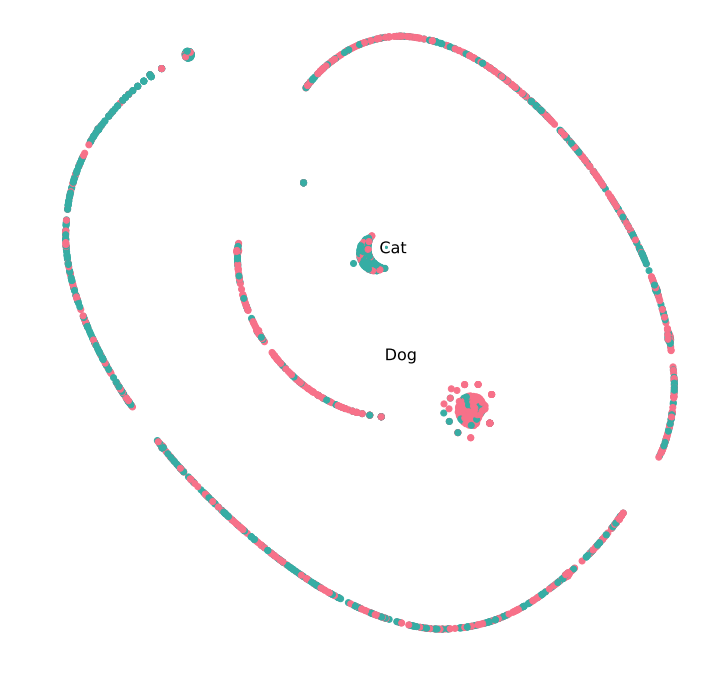

In [87]:
# visualize t-SNE output
data_scatter(cats_dogs_tsne, y_data)